In [11]:
import json
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,FastICA
from matplotlib import cm
from sklearn.metrics import rand_score, silhouette_score, fowlkes_mallows_score, calinski_harabasz_score, \
    homogeneity_score, mutual_info_score, davies_bouldin_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from concurrent.futures import ThreadPoolExecutor
from sklearn.random_projection import  GaussianRandomProjection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,mutual_info_classif,chi2
import yellowbrick.features.pca

from sklearn.preprocessing import LabelEncoder
import yellowbrick.cluster

In [12]:
df1 = pd.read_csv("data/Australian_Rain/balanced_australian_rain.csv",low_memory=False)

y = df1['RainTomorrow']
X = df1.drop(['RainTomorrow'],axis=1)
_y_unique_labels = y.unique().shape[0]
y=LabelEncoder().fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [13]:
save_prefix="analysis/images/"

## ICA

In [14]:
kurt=scipy.stats.kurtosis(X_train)
kmean=kurt.mean()
print(kurt)
print(kmean)

[-4.77999089e-01  1.38066320e-01  1.12871850e+02 -1.02686048e+00
  1.40208949e+00 -8.88408238e-01 -1.15217431e+00  1.23075420e+00
  7.86703564e-01 -7.53802287e-02 -5.93931579e-01  7.04538437e-01
  6.57628229e-01 -2.29761943e-01  2.69786483e-01 -1.49987194e+00
  2.27524114e+00  1.38855013e+00]
6.43226776013547


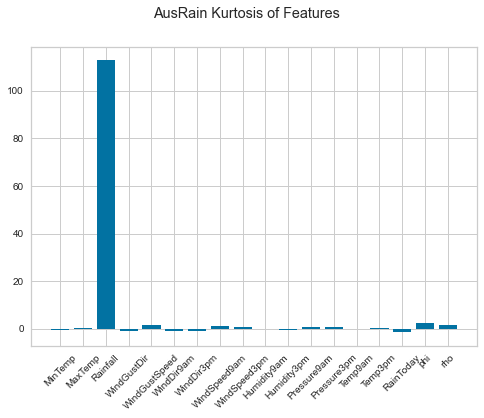

In [15]:
title=f"AusRain Kurtosis of Features"
x_points = [X_train.columns[i] for i in range(len(kurt))]
y_points = kurt
plt.bar(x_points,y_points)
plt.suptitle(title)
plt.tick_params(axis='x',labelrotation=45)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

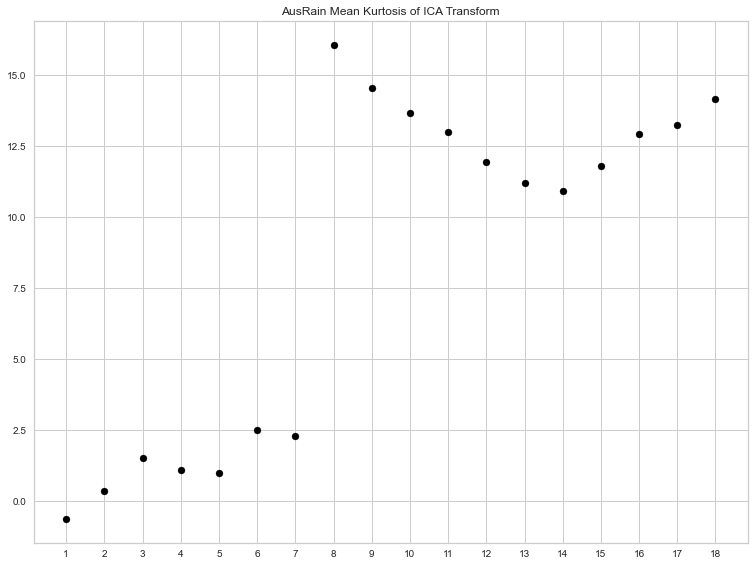

In [16]:
title=f"AusRain Mean Kurtosis of ICA Transform"
kurt = []
for i in range(1,19):
    ica_x=FastICA(n_components=i,
            whiten=True,
            fun="cube",max_iter=500,tol=1e-1).fit_transform(X_train)
    kurt.append((i,scipy.stats.kurtosis(ica_x).mean()))

fig = plt.figure(figsize=(12.8,9.6))
ax=fig.add_subplot()
ax.set_title(title)
ax.set_xticks([i for i in range(0,20)])
for i,k in kurt:
    ax.scatter(x=i,y=k,color='black')
fig.savefig(f"{save_prefix}{title.replace(' ','_')}.png")
plt.show()

In [17]:
ica_optimum = 8

In [18]:
internal_scoring_algos = {
    "si":silhouette_score,  #  measure of how tight clusters are, and how spread out they are. -1 to 1 (best)
    "ch":calinski_harabasz_score,  #  Ratio of cluster tightness to cluster dispersion.  higher ratio is tighter, more dispersed clusters
    "db":davies_bouldin_score  # measures tightness and cluster dispersion, the lower the value, the tighter and further apart they are
}
external_scoring_algos = {
    "fm":fowlkes_mallows_score,
    "hs":homogeneity_score,  # measure of how consistently samples of a given ground truth are placed into the correct cluster
    "mi":mutual_info_score,  # Determines the similarity between clusters by examining samples within different clusters and their similarity
    "rs":rand_score,  #  Measures similarity between two clusterings by considering all pairs and determining what has been assigned to same, or different, clusters
    "vs":v_measure_score, #  Measures cluster labeling to truthful labeling, irregardless of permutations of labels
}

## Clustering Selection

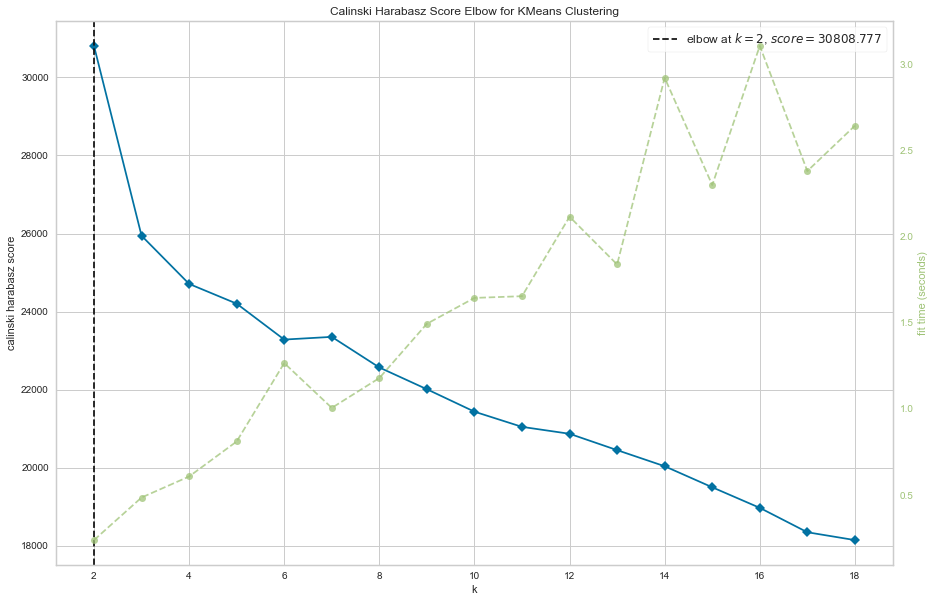

In [19]:
outpath=f"{save_prefix}AusRain_Calinski_Harabasz_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(),
    k=18,
    metric='calinski_harabasz',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal1=viz.elbow_value_


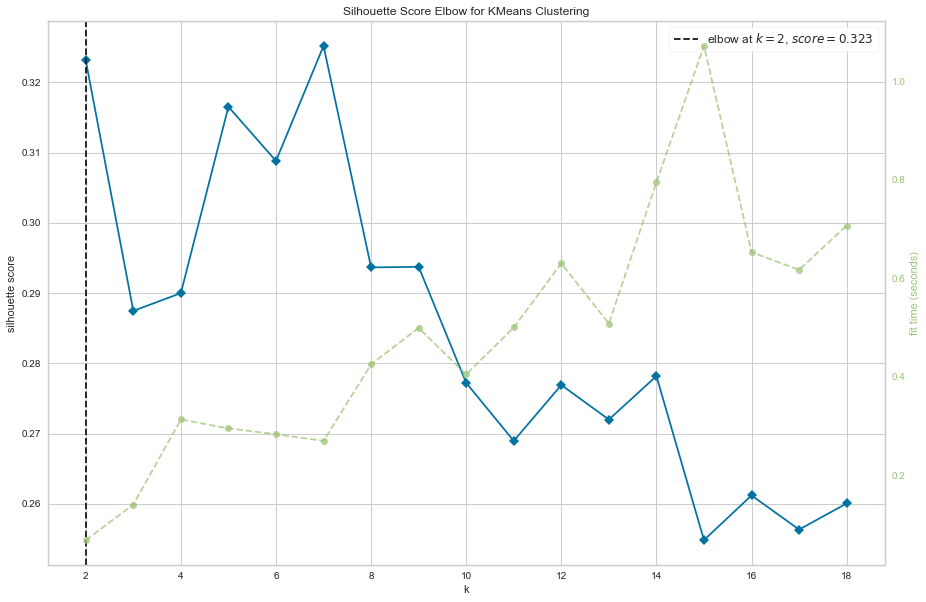

In [20]:
outpath=f"{save_prefix}AusRain_Silhouette_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(n_clusters=_y_unique_labels,n_init=3,copy_x=True,algorithm='auto'),
    k=18,
    metric='silhouette',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal2=viz.elbow_value_


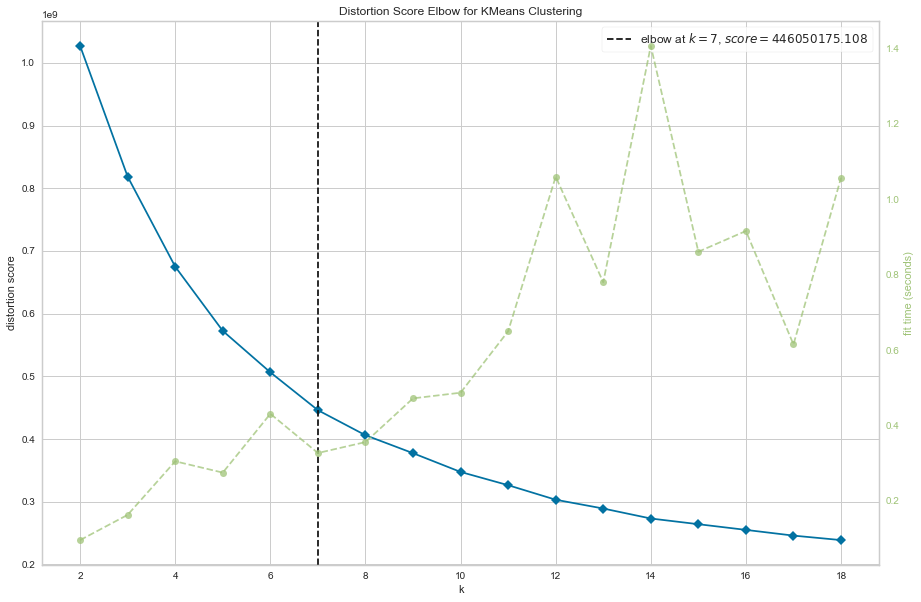

In [21]:
outpath=f"{save_prefix}AusRain_Distortion_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(n_clusters=_y_unique_labels,n_init=3,copy_x=True,algorithm='auto'),
    k=18,
    metric='distortion',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal3=viz.elbow_value_


## Clustering Visualization

c:\users\james\pycharmprojects\ml_hw_03\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


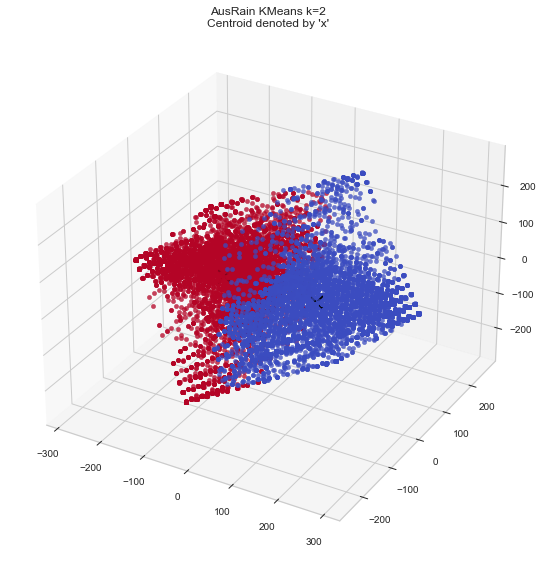

c:\users\james\pycharmprojects\ml_hw_03\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


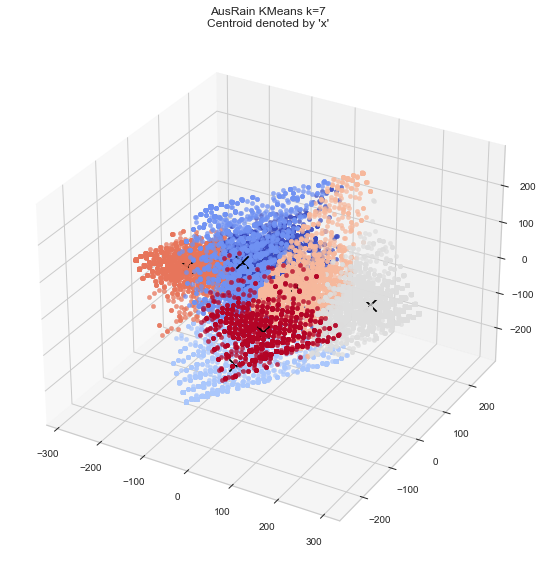

In [22]:
scores = {}
for k in set([k_optimal3,k_optimal2,k_optimal1]):
    model = KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto')
    model.fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    centroids = pca.transform(model.cluster_centers_)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(f"AusRain KMeans k={k}\nCentroid denoted by 'x'")
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=0.75)
    for i in range(len(centroids)):
        color='black'
        x,y,z=centroids[i]
        marker = 'x'
        ax.scatter(x,y,z,
                   color=color,
                   marker=marker,
                   alpha=1.0,
                   s=170-(len(centroids)**1.5))
    plt.show()
    internal_scores = {name:f(X_test,pred) for name,f in internal_scoring_algos.items()}
    external_scores = {name:f(y_test,pred) for name,f in external_scoring_algos.items()}
    scores[k]={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }

## Clustering Scoring



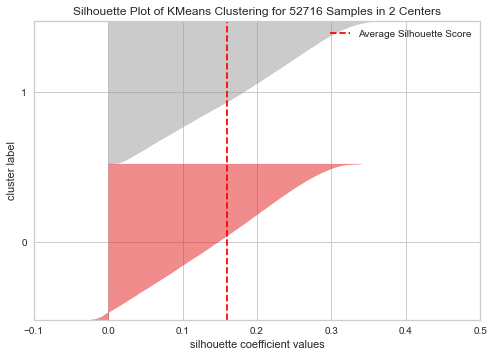

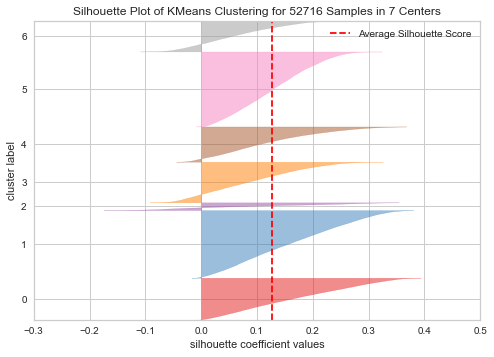

In [23]:
for k in set([k_optimal3,k_optimal2,k_optimal1]):
    outpath=f"{save_prefix}AusRain_Silhouette_Plot_{k}_clusters.png"
    scaler=StandardScaler().fit(X_train)
    scaled_x=scaler.transform(X_train)
    pca=PCA(0.91).fit(scaled_x)
    pca_x = pca.transform(scaled_x)
    viz = yellowbrick.cluster.SilhouetteVisualizer(
        estimator=KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto'),
    )
    viz.fit(pca_x)
    viz.show(outpath=outpath)
    viz.show()


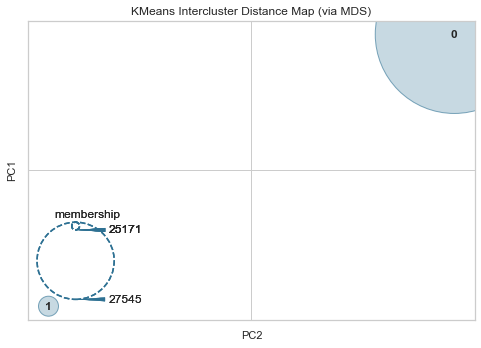

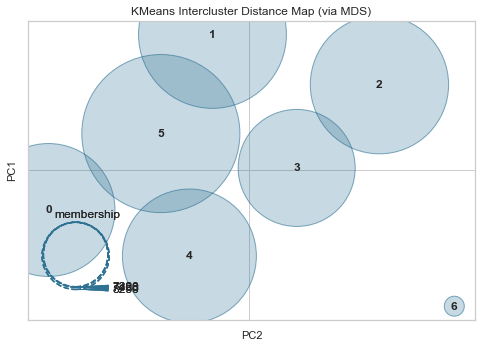

In [24]:
for k in set([k_optimal3,k_optimal2,k_optimal1]):
    outpath=f"{save_prefix}AusRain_InterclusterDistance_k={k}.png"
    viz = yellowbrick.cluster.InterclusterDistance(KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto'))
    viz.fit(pca_x)
    viz.show(outpath=outpath)
    viz.show()

In [25]:
print(scores)

{2: {'internal_scores': {'si': 0.32108631761158307, 'ch': 10099.105425322805, 'db': 1.194540902837839}, 'external_scores': {'fm': 0.5069953657796972, 'hs': 0.010113690415401767, 'mi': 0.007010215064077896, 'rs': 0.5069701570330879, 'vs': 0.010114390724979695}}, 7: {'internal_scores': {'si': 0.2868818171343281, 'ch': 7432.4393633034715, 'db': 1.1705999613476297}, 'external_scores': {'fm': 0.29227801747278975, 'hs': 0.018888301516262404, 'mi': 0.013092259144347959, 'rs': 0.5036147803933587, 'vs': 0.010194859454906457}}}
